In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from shapely import Polygon, Point
import tqdm
from collections import defaultdict

In [2]:
def _get_vertices(centroid, n=3, d=1.):
    if n == 1:
        return np.array([centroid])

    centroid = np.array(centroid)
    vertices = []

    central_angle = 2 * np.pi / n

    radius = (d / 2) / np.sin(central_angle / 2)

    for i in range(n):
        theta = i * central_angle

        vertex = centroid + radius * np.array([np.cos(theta), np.sin(theta)])

        vertices.append(vertex)

    return np.array(vertices)


def _sample_poi(points, poi_position_offset, n=1):
    match len(points):
        case 1:
            # If there are only one point, sample a point away from the point at distance noise
            poi_position = points[0] + np.random.uniform(-poi_position_offset, poi_position_offset, (2,))
            return poi_position
        case 2:
            # If there are only two points, sample a point from their mid-point with radius of their half distance
            # mid = (points[0] + points[1]) / 2.0

            radius = np.random.uniform(0, poi_position_offset, size=n)

            angle = np.random.uniform(-np.pi, np.pi, size=n)

            # result = mid[:, None] + radius * np.stack((np.cos(angle), np.sin(angle)), axis=0)

            # Sample a poi around the cassie
            result = points[np.random.randint(0, len(points))][:, None] + radius * np.stack(
                (np.cos(angle), np.sin(angle)), axis=0)

            if n == 1:
                return result[:, 0]
        case _:
            # If there are more than two points, sample a point inside the polygon
            polgyon = Polygon(points)

            result = []

            min_bound = np.min(points, axis=0)
            max_bound = np.max(points, axis=0)

            while len(result) < n:
                point = np.random.uniform(min_bound, max_bound)

                if polgyon.contains(Point(point)):
                    result.append(point)

            if n == 1:
                return result[0]

            return np.array(result)

In [7]:
rs = defaultdict(list)
thetas = defaultdict(list)

n_samples = 1000
position_offset = 1
poi_position_offset = 1.5
poi_heading_range = 1.05

for num_cassie in tqdm.tqdm(range(2, 11)):

    vertices = _get_vertices([0, 0], num_cassie, d=1.5)

    for _ in range(n_samples):
        vertices_ = copy.deepcopy(vertices)
        vertices_ += np.random.uniform(-position_offset / 2, position_offset / 2, (num_cassie, 2))

        poi_position = _sample_poi(vertices_, poi_position_offset)

        # plt.scatter(vertices_[:, 0], vertices_[:, 1], c='r')
        # plt.scatter(poi_position[0], poi_position[1], c='b')

        r = np.linalg.norm(poi_position - vertices_, axis=1)
        theta = np.arctan2(poi_position[1] - vertices_[:, 1],
                           poi_position[0] - vertices_[:, 0])

        theta = (theta + np.pi) % (2 * np.pi) - np.pi

        rs[num_cassie].extend(r.flatten())
        thetas[num_cassie].extend(theta.flatten())

100%|██████████| 9/9 [00:00<00:00, 19.97it/s]


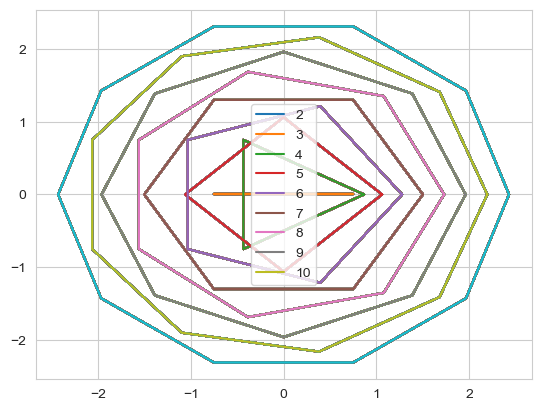

In [19]:
for i in range(2, 11):
    vertices = _get_vertices([0, 0], i, d=1.5)

    vertices = np.concatenate([vertices, vertices[0][None]], axis=0)
    plt.plot(vertices[:, 0], vertices[:, 1])

plt.legend(np.arange(2, 11))

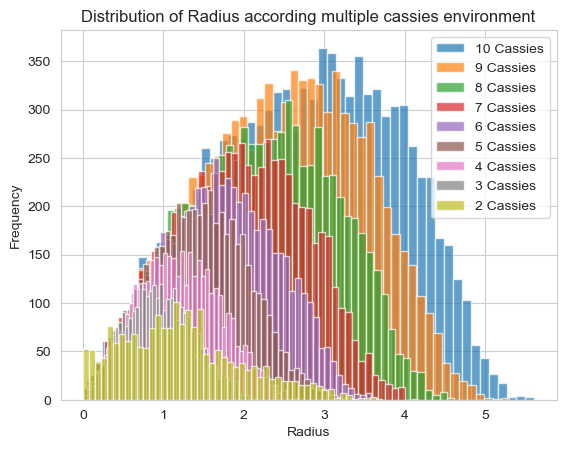

In [5]:
ks = list(rs.keys())[::-1]
for k in ks:
    plt.hist(rs[k], bins=50, alpha=0.7)
plt.legend([f'{k} Cassies' for k in ks])
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.title('Distribution of Radius according multiple cassies environment')
plt.show()

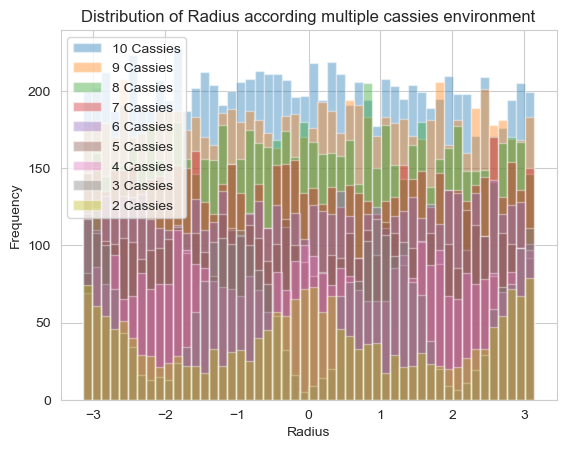

In [6]:
ks = list(thetas.keys())[::-1]
for k in ks:
    plt.hist(thetas[k], bins=50, alpha=0.4)
plt.legend([f'{k} Cassies' for k in ks])
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.title('Distribution of Radius according multiple cassies environment')
plt.show()